# 惩罚回归
过拟合：指不仅拟合了数据中的信号，而且拟合了很多噪音。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.linear_model import Lasso,lasso_path,LassoCV,Ridge,RidgeCV,ElasticNet,ElasticNetCV,enet_path
from sklearn.preprocessing import StandardScaler

# 一、数据处理
该数据包含97个前列腺患者的数据，响应变量为lpsa（log of prostate specific antigen）,前列腺特异抗原对数。

In [2]:
data=pd.read_csv('/Users/singal/Desktop/MLPython_Data/prostate.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
dtypes: float64(5), int64(4)
memory usage: 6.9 KB


In [4]:
data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


StandardScaler类，作用是将数据标准化。操作方式为：
1. 生成一个scaler实例。
2. 使用fit_transform方法或者依次使用fit和transform方法生成数据，dtype=array

In [5]:
X_raw=data.iloc[:,:-1]
y=data.iloc[:,-1]
scaler=StandardScaler()
X=scaler.fit_transform(X_raw)#生成的X为array

In [6]:
X.mean(axis=0)

array([ 4.57823928e-17,  2.89573634e-16,  4.13186095e-16, -2.43218962e-17,
       -3.66259142e-17,  3.66259142e-17, -2.17466366e-17,  5.63695711e-17])

In [7]:
X.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

# 二、岭回归
1. 理论基础：在严格多重共线性下，不存在唯一的OLS估计量$\hat\beta_{OLS}$，即存在许多$\hat\beta_{OLS}$，都能使$SSR=0$且$R^2=1$。为得到参数向量$\beta$的唯一解，必须对其取值范围作出限制，进行正则化（regularization）。故在损失函数中加入惩罚项。
$$\underset{\beta}{min}\quad L(\beta)=(y-X\beta)^{'}(y-X\beta)+\lambda||\beta||_2^2$$
2. 岭回归估计量：在矩阵$X^{'}X$的主对角线上均加入一常数$\lambda>0$称为调节参数，以缓解多重共线性，由此可得岭回归估计量。
$$\hat\beta_{Ridge}=(X^{'}X+\lambda I)^{-1}X^{'}y$$
3. 均方误差为方差和偏差平方之和，虽然岭回归估计量是有偏的，但可大幅减少方差，从而使得岭回归估计量的均方误差可能比OLS估计量更小。
$$MSE(\hat\beta)=var(\hat\beta)+\left[Bias(\hat\beta)\right]^2$$

## 1、估计模型、计算r2和回归系数

In [8]:
model=Ridge()
model.fit(X,y)#调节参数alpha默认为1
model.score(X,y)

0.6632704474129987

In [9]:
pd.DataFrame(model.coef_,index=X_raw.columns,columns=['coefficient'])

,coefficient
lcavol,0.647349
lweight,0.264235
age,-0.151790
lbph,0.136945
svi,0.308259
lcp,-0.130742
gleason,0.037551
pgg45,0.119078


## 2、系数路径图
sklearn模块无Bridge系数路径图的对应函数，对于lasso和Elastic Net有系数路径的生成函数。

Text(0, 0.5, 'Coefficients')

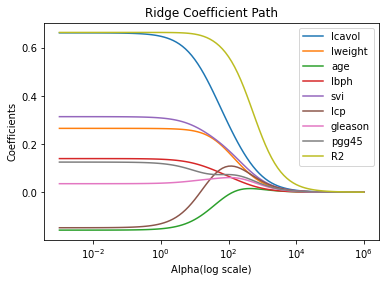

In [10]:
alphas=np.logspace(-3,6,100)
coefs_r2=[]
for alpha in alphas:
    model=Ridge(alpha=alpha)
    model.fit(X,y)
    temp=model.coef_.tolist()#作用是转化为list，以便append r2
    temp.append(model.score(X,y))
    coefs_r2.append(temp)
plt.xscale('log')
plt.plot(alphas,coefs_r2)
columns=X_raw.columns.tolist()
columns.append('R2')
plt.legend(columns)
plt.title('Ridge Coefficient Path')
plt.xlabel('Alpha(log scale)')
plt.ylabel('Coefficients')

## 3、小样本下选择最优调节参数alpha
小样本下应选择留一交叉验证，以扩大训练集容量，提高估计效率。

RidgeCV类：cv:default=none，默认使用留一交叉验证法，只有使用该方法才能得到每个alpha的均方误差MSE，即store_cv_values=True，才有意义。

In [11]:
model=RidgeCV(alphas=alphas)#初步确定大致范围
model.fit(X,y)
model.alpha_

/Users/singal/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1421: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


6.5793322465756825

In [12]:
alphas=np.linspace(1,10,1000)#再次精确范围
model=RidgeCV(alphas=alphas,store_cv_values=True)
model.fit(X,y)
model.alpha_

/Users/singal/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1421: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


6.018018018018018

观察交叉验证结果的维数，以便后续取均值时选择axis=0 or 1。

In [13]:
model.cv_values_.shape

(97, 1000)

In [14]:
mse=model.cv_values_.mean(axis=0)
index_min=np.argmin(mse)
alphas[index_min]

6.018018018018018

所得最优alpha与上文相同。

Text(0, 0.5, 'Mean Squard Error')

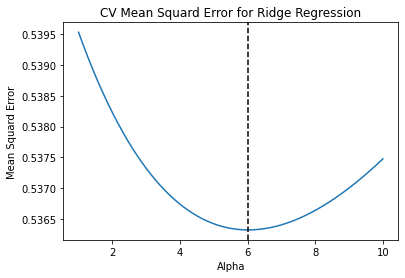

In [15]:
plt.plot(alphas,mse)
plt.axvline(alphas[index_min],linestyle='--',color='k')#垂直于x轴画一条线
plt.title('CV Mean Squard Error for Ridge Regression')
plt.xlabel('Alpha')
plt.ylabel('Mean Squard Error')

最佳模型的回归系数：

In [16]:
pd.DataFrame(model.coef_,index=X_raw.columns,columns=['Coefficient'])

,Coefficient
lcavol,0.588011
lweight,0.258793
age,-0.128279
lbph,0.125946
svi,0.286343
lcp,-0.066195
gleason,0.044772
pgg45,0.098707


## 4、大样本下选择最优调节参数
大样本下应使用10折交叉验证，以简化计算量。

In [17]:
kfold=KFold(n_splits=10,shuffle=True,random_state=1)
model=RidgeCV(alphas=np.linspace(1,10,1000),cv=kfold)
model.fit(X,y)
model.alpha_

3.2522522522522523

# 三、Lasso回归 Least absolute shrinkage and selection operator
1. 存在依据：在进行高维回归时，有时希望从大量特征变量中筛选出真正影响$y$的少数变量，此时一般期待真实模型为稀疏模型，Lasso回归起到筛选变量的作用。
2. Lasso回归将惩罚项改为1-范数。
$$\underset{\beta}{min}\quad=(y-X\beta)^{'}(y-X\beta)+\lambda||\beta||_1$$
3. Lasso估计量，又名套索估计量,由于绝对值函数并不光滑，使得Lasso的目标函数不可微，故一般情况下不存在解析解，但损失函数是连续凸函数，故可求次微分，从而进行数值迭代算法————坐标下降法。最后，标准正交化下Lasso问题具有解析解。
$$
\beta_{k,lasso}=
\begin{cases}
\beta_{k,ols}-\frac{\lambda}{2} & \beta_{k,ols}>\frac{\lambda}{2} \\
\beta_{k,ols}+\frac{\lambda}{2} & \beta_{k,ols}<\frac{\lambda}{2} \\
0 & \beta_{k,ols}\in[-\frac{\lambda}{2},\frac{\lambda}{2}] \\
\end{cases}$$
4. Lasso估计量不仅收缩回归系数，而且在收缩过程中使得各变量的回归系数依次变为0，故具有筛选变量、得到稀疏矩阵的作用。

## 1、估计模型、计算r2和回归系数

In [18]:
model=Lasso()
model.fit(X,y)
model.score(X,y)

0.0

In [19]:
model.coef_

array([0., 0., 0., 0., 0., 0., 0., 0.])

r2和回归系数均为0，表明调节参数取值过大，Lasso类默认取值为1。

In [20]:
model=Lasso(alpha=0.1)#改为0.1
model.fit(X,y)
model.score(X,y)

0.6261113876338473

## 2、系数路径图
1. lasso_path函数返回4个值。
2. eps表示alpha最小值除以最大值1e-4，n_alphas表示alpha个数。
3. 既可以指定alphas，也可以指定eps和n_alphas。

In [21]:
alphas,coefs=lasso_path(X,y,eps=1e-4)[:2]
alphas.shape,coefs.shape

((100,), (8, 100))

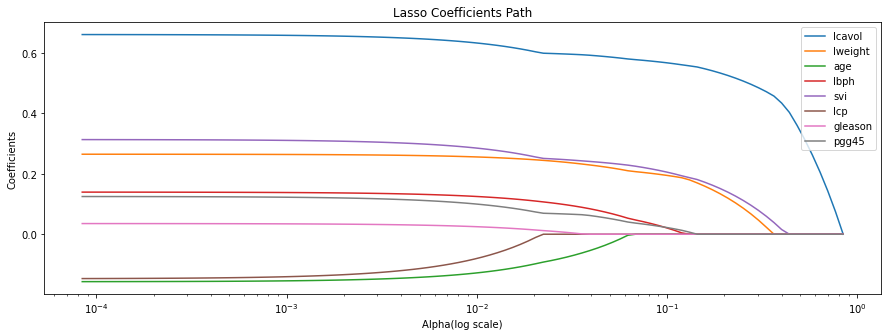

In [22]:
plt.figure(figsize=(15,5))
plt.plot(alphas,coefs.T)
plt.xscale('log')
plt.legend(X_raw.columns)
plt.xlabel('Alpha(log scale)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients Path')
plt.axvline(0,linestyle='--',color='k')

## 3、确定最优参数

In [23]:
alphas=np.logspace(-4,-2,100)
model=LassoCV(alphas=alphas,cv=kfold)
model.fit(X,y)
model.alpha_

0.007220809018385471

In [24]:
model.mse_path_.shape

(100, 10)

In [25]:
mse=np.mean(model.mse_path_,axis=1)
index_min=np.argmin(mse)
alphas[index_min]

0.00013848863713938732

由此所得最优参数与上文的model.alpha_输出结果不一致，故采取手动验证。验证结果与使用model.alpha_的结果一致。

0.007220809018385471

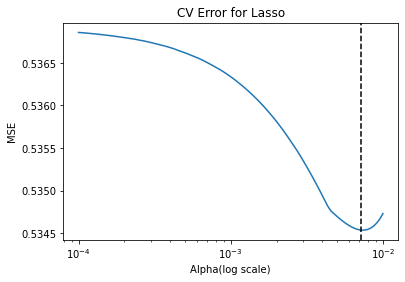

In [26]:
alphas=np.logspace(-4,-2,100)
scores=[]
for alpha in alphas:
    model=Lasso(alpha=alpha)
    scores_val=-cross_val_score(model,X,y,cv=kfold,scoring='neg_mean_squared_error')
    scores.append(np.mean(scores_val))
mse=np.array(scores)#argmin不能作用于list
index_min=np.argmin(mse)
plt.plot(alphas,scores)
plt.xscale('log')
plt.axvline(alphas[index_min],linestyle='--',color='k')
plt.xlabel('Alpha(log scale)')
plt.title('CV Error for Lasso')
plt.ylabel('MSE')
alphas[index_min]

# 四、弹性网估计量 Elastic Net
1. Lasso回归也有缺陷，如当几个变量高度相关时，lasso可能随机选择其中一个，而岭回归无法起到筛选变量的作用，故引出弹性网估计量。
2. 弹性网估计量损失函数中，同时包含1-范数$L_1$和2-范数$L_2$的惩罚项。
$$\underset{\beta}{min}\quad(y-X\beta)^{'}(y-X\beta)+\lambda_1||\beta||_1+\lambda_2||\beta||_2^2$$
3. ElasticNet类中的l1_ratio表示：
$$\alpha=\frac{\lambda_1}{\lambda_1+\lambda_2}$$
4. 故损失函数可改写为：
$$\underset{\beta}{min}\quad(y-X\beta)^{'}(y-X\beta)+\lambda\left[\alpha||\beta||_1+(1-\alpha)||\beta||_2^2\right]$$

## 1、估计模型、计算r2和回归系数

In [27]:
model=ElasticNet(alpha=0.1,l1_ratio=0.5)
model.fit(X,y)
model.score(X,y)

0.641941891532626

In [28]:
pd.DataFrame(model.coef_,index=X_raw.columns,columns=['coefficients'])

,coefficients
lcavol,0.553863
lweight,0.216887
age,-0.021952
lbph,0.065296
svi,0.236458
lcp,0.000000
gleason,0.001895
pgg45,0.059813


## 2、系数路径图
enet_path函数使用方法与lasso_path函数相同。

In [29]:
alphas,coefs=enet_path(X,y,eps=1e-4,l1_ratio=0.5)[:2]
alphas.shape,coefs.shape

((100,), (8, 100))

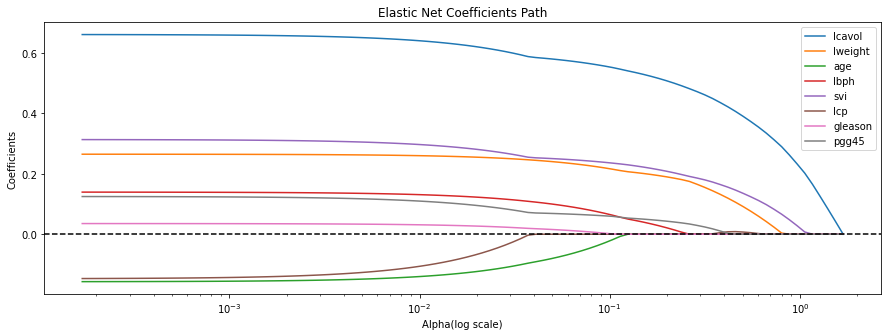

In [30]:
plt.figure(figsize=(15,5))
plt.plot(alphas,coefs.T)
plt.xscale('log')
plt.xlabel('Alpha(log scale)')
plt.ylabel('Coefficients')
plt.title('Elastic Net Coefficients Path')
plt.axhline(0,linestyle='--',color='k')
plt.legend(X_raw.columns)

## 3、确定最优参数

In [31]:
alphas=np.logspace(-4,0,100)
l1_ratio=[0.0001,0.001,0.01,0.1,0.5,1]
model=ElasticNetCV(l1_ratio=l1_ratio,alphas=alphas,cv=kfold)
model.fit(X,y)
model.score(X,y)

0.6592730190729547

In [32]:
model.alpha_,model.l1_ratio_

(0.07390722033525783, 0.0001)

最优l1_ratio为0.01，为该网格的最小值，且很接近与0，意味着$L_1$惩罚项系数应为0，故使用岭回归。
# 五、结论

In [33]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)
model=RidgeCV(alphas=np.linspace(1,20,1000))
model.fit(xtrain,ytrain)
model.alpha_

/Users/singal/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1421: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


10.756756756756758

In [34]:
model.score(xtrain,ytrain),model.score(xtest,ytest)

(0.6760210841041481, 0.4558621521505103)

结果显示，虽然训练集的$R^2$达到0.678，而测试集的$R^2$只有0.456。因此，训练集的拟合优度明显高估了模型的预测能力。